In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3062545010729836285
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 50593792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8142485000555083103
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import utils
#from preprocess_func_new import *
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
from os.path import expanduser
from sklearn import metrics
import sys
from skimage.transform import resize
# from tensorflow.python import keras
# from tensorflow.keras.applications.mobileNet import DepthwiseConv2D

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [3]:
percent=2 

In [4]:
tfrec_batch_size=1 #for path name only

In [5]:
batch_size=64

In [6]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'
                                     +str(tfrec_batch_size)+'_precent_'+str(percent))
#### note there is a misspelling "precent"
tfrec_train_directory


'../datasets/stixels/train/tfrec_batch_size_1_precent_2'

In [7]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')


In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:128]
##################

In [8]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [9]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']
    
    
    # The image and label are now correct TensorFlow types.
    return image, label

In [12]:
########## a function to print tensor values
def print_tensor(tensor):
    dataset = tf.data.TFRecordDataset(filenames=[tensor])
    dataset = dataset.map(parse)
    iterator = dataset.make_one_shot_iterator()
    images_batch, labels_batch = iterator.get_next()
    x = {'image': images_batch}
    y = labels_batch
    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init_op)
#         print (sess.run(y))
        #print (sess.run(x))
        #return(sess.run(x))
    return

In [10]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None #-1
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print('@@@')
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    print('@@@')
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    return x, y

In [11]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [12]:
def _conv_block_v1(inputs, filters, kernel, strides, is_training):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    x = tf.layers.conv2d(inputs=inputs, 
                         filters=filters, 
                         kernel_size=kernel,
                         activation=None, 
                         strides=strides,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                         padding='same'
                        )
    
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    x = tf.nn.relu(features=x)
       
    return x

In [13]:
def _dw_unit(inputs, filters, kernel, s, is_training):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
       
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    # Depthwise convolution + BN + activation
    x = tf.contrib.layers.separable_conv2d(inputs=inputs,
                                           num_outputs=None,
                                           kernel_size=kernel,
                                           depth_multiplier=1,
                                           stride=(s,s),
                                           padding='SAME',
                                           activation_fn=None, #tf.nn.relu6,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                           normalizer_fn=None
                                          )
     
    x = tf.layers.batch_normalization(inputs=x, 
                                      training=is_training
                                     )
    
    x = tf.nn.relu(features=x)
    
    # "Projection" layer + BN
    x = tf.layers.conv2d(inputs=x,
                         filters = filters,
                         kernel_size = (1, 1),
                         strides=(1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    x = tf.nn.relu(features=x)
    
   
    
    return x


In [14]:
def mobilnetV1(inputs, k, is_training):
    
    x = _conv_block_v1(inputs=inputs, filters=32, kernel=(3,3), strides=2, is_training=is_training)
    x = _dw_unit(inputs=x, filters=64,  kernel=(3,3), s=1, is_training=is_training)
    x = _dw_unit(inputs=x, filters=128, kernel=(3,3), s=2, is_training=is_training)
    x = _dw_unit(inputs=x, filters=128, kernel=(3,3), s=1, is_training=is_training)
    x = _dw_unit(inputs=x, filters=256, kernel=(3,3), s=2, is_training=is_training)
    x = _dw_unit(inputs=x, filters=256, kernel=(3,3), s=1, is_training=is_training)
    x = _dw_unit(inputs=x, filters=512, kernel=(3,3), s=2, is_training=is_training)
    for i in range(5):
        x = _dw_unit(inputs=x, filters=512, kernel=(3,3), s=1, is_training=is_training)
    
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(24,2), strides=(1,1))
    
    # Eventually this should be replaced with:
    x = tf.layers.flatten(x)

    # This is the last layer so it does not use an activation function.
    x = tf.layers.dense(inputs=x, name='layer_fc6',
                          units=k,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    
    return x

In [14]:
# the next four cells are a modification of https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py
def _conv_block(inputs, filters, kernel, strides, is_training):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    x = tf.layers.conv2d(inputs=inputs, 
                         filters=filters, 
                         kernel_size=kernel,
                         activation=None, 
                         strides=strides,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                         padding='same'
                        )
    
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
       
    return x


In [15]:
def _bottleneck(inputs, filters, kernel, t, s, is_training, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    
    num_filters_in = utils.last_dimension(inputs.get_shape(), min_rank=4)
    
    # "Expension layer" + BN + activation
    x = _conv_block(inputs=inputs, 
                    filters=num_filters_in*t, 
                    kernel=(1, 1), 
                    strides=(1, 1), 
                    is_training=is_training)
    
    # Depthwise convolution + BN + activation
    x = tf.contrib.layers.separable_conv2d(inputs=x,
                                           num_outputs=None,
                                           kernel_size=kernel,
                                           depth_multiplier=1,
                                           stride=(s,s),
                                           padding='SAME',
                                           activation_fn=None, #tf.nn.relu6,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                           normalizer_fn=None
                                          )
     
    x = tf.layers.batch_normalization(inputs=x, 
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
    
    # "Projection" layer + BN
    x = tf.layers.conv2d(inputs=x,
                         filters = filters,
                         kernel_size = (1, 1),
                         strides=(1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    if r:
        x = tf.add(x, inputs)
        
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    '''
    
    return x


In [16]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n, is_training):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs=inputs, 
                    filters=filters, 
                    kernel=kernel, 
                    t=t, 
                    s=strides, 
                    is_training=is_training
                   )
        
    for i in range(1, n):
        x = _bottleneck(inputs=x, 
                        filters=filters, 
                        kernel=kernel, 
                        t=t, 
                        s=1, 
                        is_training=is_training, 
                        r=True
                       )

    return x


In [17]:
def MobileNetV2(inputs, k, is_training):
    """MobileNetV2
    This function defines a MobileNetV2 architectures.
    # Arguments
        inputs: A tensor of the input of shape [-1,W,H,C].
        k: Integer, number of classes.
        is_training: boolean indication training or prediction
    # Returns
        MobileNetV2 model.
    """

    
    
    
    x = _conv_block(inputs=inputs, filters=32, kernel=(3, 3), strides=(2, 2), is_training=is_training)
    
    x = _inverted_residual_block(inputs=x, filters=16,  kernel=(3, 3), t=1, strides=1, n=1, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=24,  kernel=(3, 3), t=6, strides=2, n=2, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=32,  kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=64,  kernel=(3, 3), t=6, strides=2, n=4, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=96,  kernel=(3, 3), t=6, strides=1, n=3, is_training=is_training)
        
#     x = _inverted_residual_block(inputs=x, filters=16,  kernel=(7, 3), t=1, strides=1, n=1, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=24,  kernel=(7, 3), t=6, strides=2, n=2, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=32,  kernel=(7, 3), t=6, strides=2, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=64,  kernel=(7, 3), t=6, strides=2, n=4, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=96,  kernel=(7, 3), t=6, strides=1, n=3, is_training=is_training)

#     x = _inverted_residual_block(inputs=x, filters=160, kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=320, kernel=(3, 3), t=6, strides=1, n=1, is_training=is_training)
    
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(24,2), strides=(1,1))
    
    # Eventually this should be replaced with:
    x = tf.layers.flatten(x)


    # This is the last layer so it does not use an activation function.
    x = tf.layers.dense(inputs=x, name='layer_fc6',
                          units=k,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    '''
    x = _conv_block(inputs=x, filters=1280, kernel=(1, 1), strides=(1, 1), is_training=is_training)
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(2000,2000), strides=(1,1), padding='same')
    x = tf.reshape(x, [-1,1,1,1280])
    #x = tf.layers.dropout(inputs=x, rate=0.3, seed=481, training=is_training)
    x = tf.layers.conv2d(inputs=x,
                         filters = k,
                         kernel_size = (1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    '''
    '''
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
    '''
    

    return x

In [26]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
   
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_training = True
    else:
        is_training = False
    
    # Reference to the tensor named "image" in the input-function.    
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    inputs = tf.reshape(x, [-1,H,W,C])
    
    net = MobileNetV2(inputs=inputs, k=47, is_training=is_training)
#     net = mobilnetV1(inputs=inputs, k=47, is_training=is_training)
    
    
    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
#######################
        lr = 1e-4
        step_rate = 5000
        decay = 0.7 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        
        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        
        ''' original
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        '''
        # for learning parameters of batch normalization:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        
#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)


        tf.summary.scalar("accuracy", metrics["accuracy"][1]) 
        merge_summary_op = tf.summary.merge_all()


            
    return spec

In [16]:
params = {} #{"learning_rate": 1e-5}

In [17]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [27]:
# model_dir = './ckpts_30_5_mobilenetV2_47bins_03_swap_1' #./ckpts_<day>_<month>_<architecture>_<main_change>'
# model_dir = './ckpts_01_06_mobilenetV2_47bins_kernel_3_3' #./ckpts_<day>_<month>_<architecture>_<main_change>'
# model_dir = './ckpts_02_06_mobilenetV2_47bins_3x3_relu_fixed'
model_dir = 'ckpts_02_06_mobilenetV1_47bins_5e_minus2_80k'

make_dir_and_comment(model_dir) 
# model = tf.estimator.Estimator(model_fn=model_fn,
#                                params=params,
#                                model_dir=model_dir)

model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               #config=tf.estimator.RunConfig(save_checkpoints_steps=1000, save_summary_steps=100)
                               config=tf.estimator.RunConfig().replace(save_checkpoints_steps=1000,save_summary_steps=10)
                              )

INFO: dir with name ckpts_02_06_mobilenetV1_47bins_5e_minus2_80k already exist.
Please add a comment
////
INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_num_ps_replicas': 0, '_global_id_in_cluster': 0, '_num_worker_replicas': 1, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6636a508d0>, '_model_dir': 'ckpts_02_06_mobilenetV1_47bins_5e_minus2_80k', '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': 1000, '_evaluation_master': '', '_task_id': 0, '_save_summary_steps': 10, '_is_chief': True, '_session_config': None, '_service': None, '_master': '', '_task_type': 'worker', '_tf_random_seed': None}


In [28]:
model.train(input_fn=train_input_fn, steps=80000)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_01_06_mobilenetV2_47bins_kernel_3_3/model.ckpt.
INFO:tensorflow:step = 0, loss = 4.045549
INFO:tensorflow:global_step/sec: 4.08069
INFO:tensorflow:step = 100, loss = 3.826424 (24.507 sec)
INFO:tensorflow:global_step/sec: 5.17529
INFO:tensorflow:step = 200, loss = 3.8021762 (19.323 sec)
INFO:tensorflow:global_step/sec: 5.11984
INFO:tensorflow:step = 300, loss = 3.7437038 (19.532 sec)
INFO:tensorflow:global_step/sec: 5.17197
INFO:tensorflow:step = 400, loss = 3.5925136 (19.335 sec)
INFO:tensorflow:global_step/sec: 5.15006
INFO:tensorflow:step = 500, loss = 3.6040573 (19.417 sec)
INFO:ten

In [115]:
###DONE TRAIN###

In [28]:
#performance on training dataset:
def train_partial_input_fn():
    return input_fn(path_tfrecords_train_lst[7000:7500], train=False) 
#     return input_fn(path_tfrecords_train_lst, train=False) 

train_partial_result = model.evaluate(input_fn=train_partial_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-03-06:32:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ckpts_02_06_mobilenetV1_47bins_5e_minus2_80k/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


ResourceExhaustedError: OOM when allocating tensor with shape[64,3,371,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'conv2d/Conv2D', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2902, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3006, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3066, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-1ad52246b683>", line 6, in <module>
    train_partial_result = model.evaluate(input_fn=train_partial_input_fn)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 417, in evaluate
    name=name)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 931, in _evaluate_model
    features, labels, model_fn_lib.ModeKeys.EVAL, self.config)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 805, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-26-92d82b6da785>", line 22, in model_fn
    net = mobilnetV1(inputs=inputs, k=47, is_training=is_training)
  File "<ipython-input-14-5835a26aee06>", line 3, in mobilnetV1
    x = _conv_block_v1(inputs=inputs, filters=32, kernel=(3,3), strides=2, is_training=is_training)
  File "<ipython-input-12-1a590d21d9a5>", line 22, in _conv_block_v1
    padding='same'
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 619, in conv2d
    return layer.apply(inputs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 825, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 714, in __call__
    outputs = self.call(inputs, *args, **kwargs)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 168, in call
    outputs = self._convolution_op(inputs, self.kernel)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 870, in __call__
    return self.conv_op(inp, filter)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 522, in __call__
    return self.call(inp, filter)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 206, in __call__
    name=self.name)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 953, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,3,371,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: conv2d/Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
#VAL:

In [24]:
tfrec_val_batch_size=1

In [25]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'
                                   +str(tfrec_val_batch_size))#+'_percent_'+str(percent))

In [26]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [27]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst, train=False) 

In [34]:
val_result = model.evaluate(input_fn=val_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-02-06:18:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_01_06_mobilenetV2_47bins_kernel_3_3/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-02-06:52:31
INFO:tensorflow:Saving dict for global step 80000: accuracy = 0.40708977, global_step = 80000, loss = 1.6197819


In [51]:
val_result

{'accuracy': 0.26630434, 'global_step': 100000, 'loss': 2.224182}

In [52]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 26.63%


In [ ]:
#TEST:

In [162]:
tfrec_test_batch_size=1

In [163]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [164]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [167]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:2500], train=False)

In [260]:
test_result = model.evaluate(input_fn=test_input_fn)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-29-04:20:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR_withAvg2/model.ckpt-135001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-29-04:20:13
INFO:tensorflow:Saving dict for global step 135001: accuracy = 0.19497283, global_step = 135001, loss = 2.7235723


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [22]:
sum_csv_test_path = os.path.join(img_path,'test', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_test_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'test', name+'.png')) #maybe no need to add '.png'


In [224]:
##TODO:SHUFFLE!
some_num=1500
some_images = load_images(image_paths=image_paths_test[7000:7000+some_num])
some_images_cls = np.array(labels_test['Label'])

In [27]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [28]:
# predictions = model.predict(input_fn=predict_input_fn)
# predictions for val
predictions = model.predict(input_fn=val_input_fn)


In [27]:
predictions

<generator object Estimator.predict at 0x7fb123a487d8>

In [29]:
cls_pred_v2_7_3 = np.array(list(predictions))
len(cls_pred_v2_7_3)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_30_5_mobilenetV2_47bins_03_swap_1/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


117888

In [34]:
cls_pred.shape

(117888,)

In [235]:
np.histogram(some_images_cls, bins= [x for x in range(0, 47, 1)])


(array([    0,     5,     5,    21,    71,   313,   150,  1079,  3691,
         6280, 11605, 13872, 16378, 17646, 19292, 18101, 19392, 17603,
        16215, 15047, 14708, 15527, 14560, 14073, 14708, 13082, 13245,
        12922, 10970, 11509, 10997, 10722, 10903,  9856,  9444,  9308,
         7769,  5462,  2876,  1092,   241,    23,     0,     0,     0,
         7815]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [35]:
np.histogram(cls_pred, bins= [x for x in range(0, 47, 1)])


(array([   0,    0,    0,    0,    3,  101,   11,  109,  990, 1530, 3529,
        4319, 5280, 5354, 6056, 5253, 6157, 5445, 4703, 4465, 4378, 4679,
        4376, 4452, 4726, 3291, 3713, 4195, 3087, 3355, 3087, 2931, 3322,
        2568, 2604, 2827, 2262, 1755,  610,  160,    2,    0,    0,    0,
           0, 2203]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [178]:
cls_pred[67]


array([3.63838133e-08, 5.23802601e-06, 2.41361181e-06, 8.22993752e-06,
       6.88640721e-05, 6.73187096e-05, 1.12743000e-04, 2.48558167e-03,
       2.41161394e-03, 1.98379252e-03, 1.63461361e-03, 3.52152251e-03,
       4.75671981e-03, 8.01659003e-03, 9.75785963e-03, 8.38503707e-03,
       5.74642140e-03, 7.23679783e-03, 7.88456481e-03, 1.14491200e-02,
       1.59071349e-02, 1.35434372e-02, 5.99773182e-03, 4.06883238e-03,
       6.72300300e-03, 8.37637670e-03, 1.83306281e-02, 2.76202224e-02,
       2.98272502e-02, 2.47496460e-02, 1.82593651e-02, 4.35408838e-02,
       2.88887601e-02, 3.89404297e-02, 9.61616039e-02, 1.31164491e-01,
       6.05020821e-02, 3.79621610e-02, 1.50133632e-02, 7.29497289e-03,
       4.58270835e-04, 1.19983735e-04, 5.25741832e-08, 3.36415056e-08,
       4.82108398e-08, 3.18117941e-08, 2.91014105e-01], dtype=float32)

In [202]:
np.argmax(cls_pred,axis=1)


array([46, 46, 46, ..., 46, 46, 46])

In [203]:
np.histogram(np.argmax(cls_pred,axis=1), bins= [x for x in range(0, 47, 1)])

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1500]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [125]:
np.argmax(cls_pred,axis=1).shape

(100,)

In [144]:
np.argmax(cls_pred[1])

46

In [145]:
y_pred_cls = tf.argmax(cls_pred, axis=1) 

In [146]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(100,) dtype=int64>

In [147]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y_pred_cls))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46]


In [37]:
# extract ground truth data
dataset = tf.data.TFRecordDataset(filenames=path_tfrecords_val_lst)
dataset = dataset.map(parse)
iterator = dataset.make_one_shot_iterator()
images_batch, labels_batch = iterator.get_next()
x = {'image': images_batch}
y = labels_batch
GTlabels=[]
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
    for i in range(len(path_tfrecords_val_lst)):
        sess.run(init_op)
        GTlabels.append(sess.run(y))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [43]:
def calculate_AUC_fast(y_pred_cls, GT, num_classes):
    if max(y_pred_cls) < 17 and num_classes==47:
        print("Wrong number of classes! Check input the AUC func!")
    if max(y_pred_cls) > 16 and num_classes==17:
        print("Wrong number of classes! Check input the AUC func!")
    px_in_bin = (370-140)/(num_classes-1)
    
    
    diff_vec = [abs(number) for number in np.subtract(y_pred_cls,GT)]
    error_count = np.zeros(num_classes)
    for i in range(len(y_pred_cls)):
        error_count[diff_vec[i]] += 1
        
        
    auc_acc = np.cumsum(error_count)
    
    
    error_px_vec = [px_in_bin/2 + i*px_in_bin for i in range(num_classes)]
    total = len(y_pred_cls)
    auc_acc /= total
    
    return error_px_vec, auc_acc

In [39]:
x47,y47 = calculate_AUC_fast(y_pred_cls=cls_pred, GT=GTlabels[:len(cls_pred)], num_classes=num_classes)
x47=np.insert(x47, 0, 0)
y47=np.insert(y47, 0, 0)

In [40]:
print(x47)
print(y47)

[  0.    2.5   7.5  12.5  17.5  22.5  27.5  32.5  37.5  42.5  47.5  52.5
  57.5  62.5  67.5  72.5  77.5  82.5  87.5  92.5  97.5 102.5 107.5 112.5
 117.5 122.5 127.5 132.5 137.5 142.5 147.5 152.5 157.5 162.5 167.5 172.5
 177.5 182.5 187.5 192.5 197.5 202.5 207.5 212.5 217.5 222.5 227.5 232.5]
[0.         0.40708978 0.78896071 0.87533931 0.903807   0.91911815
 0.92982322 0.93870453 0.94553305 0.950682   0.95553407 0.95909677
 0.96222686 0.96540784 0.96795263 0.9703108  0.97237208 0.97406012
 0.97569727 0.97732594 0.97885281 0.98028637 0.9813976  0.98285661
 0.98384059 0.98507058 0.98608001 0.98702158 0.9879886  0.98909982
 0.99012622 0.990966   0.9919415  0.9929679  0.9938501  0.99496132
 0.9965815  0.99803203 0.99888029 0.99966918 0.99982186 0.99988973
 0.99994062 0.99997455 1.         1.         1.         1.        ]


In [50]:
df_preds = pd.DataFrame(GTlabels[:len(cls_pred)], columns=['GT_noa'])
pd.DataFrame.to_csv(df_preds,'GT_noa')

In [32]:
df_preds_7_3 = pd.DataFrame(cls_pred_v2_7_3, columns=['preds_7x3_V2'])
pd.DataFrame.to_csv(df_preds_7_3,'preds_7x3_V2')

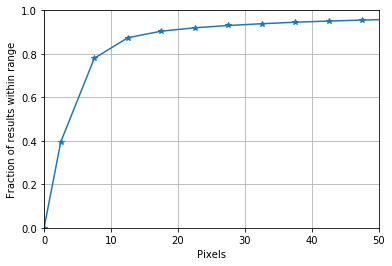

In [35]:
# Kernels 7x3
plt.figure(1)
plt.plot(x47,y47,marker='*')
plt.xlabel('Pixels')
plt.ylabel('Fraction of results within range')
plt.xlim(0,50)
plt.ylim(0,1)
plt.grid(True)

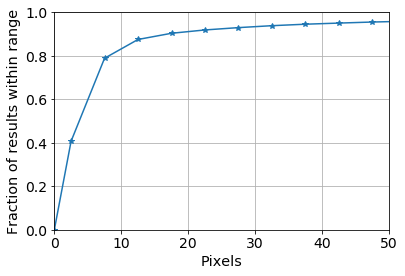

In [48]:
# Kernels 3x3
plt.figure(3)
plt.plot(x47,y47,marker='*')
plt.xlabel('Pixels')
plt.ylabel('Fraction of results within range')
plt.xlim(0,50)
plt.ylim(0,1)
plt.grid(True)
plt.rcParams.update({'axes.labelsize': 'x-large'})
plt.rcParams.update({'axes.titlesize': 'x-large'})
plt.tick_params(axis='both', which='major', labelsize=14)

In [42]:
# AUC for 47 bins, kernerls 3x3
AUC_475 = np.trapz(y=y47[:11], x=x47[:11])/x47[10] # up until 47.5 pixel error
AUC_525 = np.trapz(y=y47[:12], x=x47[:12])/x47[11] # up until 52.5 pixel error
AUC_50 = (AUC_475+AUC_525)/2
print('47.5, AUC= ',AUC_475)
print('52.5, AUC= ', AUC_525)
print('50,   AUC= ', AUC_50)

47.5, AUC=  0.8457949829275959
52.5, AUC=  0.8564159767462903
50,   AUC=  0.8511054798369431


In [52]:
# AUC for 47 bins, kernerls 7x3
AUC_475 = np.trapz(y=y47[:11], x=x47[:11])/x47[10] # up until 47.5 pixel error
AUC_525 = np.trapz(y=y47[:12], x=x47[:12])/x47[11] # up until 52.5 pixel error
AUC_50 = (AUC_475+AUC_525)/2
print('47.5, AUC= ',AUC_475)
print('52.5, AUC= ', AUC_525)
print('50,   AUC= ', AUC_50)

47.5, AUC=  0.8439040266586662
52.5, AUC=  0.85469703285766
50,   AUC=  0.8493005297581631


In [9]:
# analyzing performance of 17 bins
pred17_df = pd.read_csv('PREDS.csv')
preds17 = list(pred17_df['preds'])

GT17_df = pd.read_csv('VAL_GT.csv')
GT17 = list(GT17_df['GT'])


In [11]:
x17,y17 = calculate_AUC_fast(y_pred_cls=preds17, GT=GT17, num_classes=17)
x17=np.insert(x17, 0, 0)
y17=np.insert(y17, 0, 0)

print(x17)
print(y17)

[  0.       7.1875  21.5625  35.9375  50.3125  64.6875  79.0625  93.4375
 107.8125 122.1875 136.5625 150.9375 165.3125 179.6875 194.0625 208.4375
 222.8125 237.1875]
[0.         0.69665276 0.92248575 0.94916361 0.96161611 0.97048894
 0.97614685 0.98028637 0.98389149 0.98664834 0.98919313 0.99138165
 0.99387554 0.99616585 0.99919415 0.99990669 1.         1.        ]


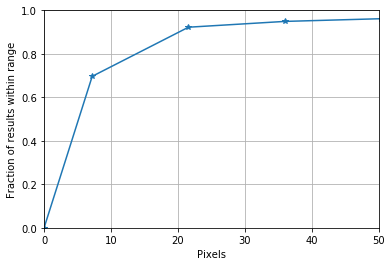

In [12]:
plt.figure(2)
plt.plot(x17,y17,marker='*')
plt.xlabel('Pixels')
plt.ylabel('Fraction of results within range')
plt.xlim(0,50)
plt.ylim(0,1)
plt.grid(True)

In [46]:
# AUC for 17 bins
AUC503 = np.trapz(y=y17[:5], x=x17[:5])/x17[4] # up until 50.3 pixel error
print('50.3, AUC= ',AUC503)


50.3, AUC=  0.8214134238793236


# Count Variables

In [29]:
# count variables in model
# np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

total_parameters = 0
for variable in model.get_variable_names():
    shape = model.get_variable_value(variable).shape
    variable_parameters = 1
    for dim in range(len(list(shape))):
        variable_parameters *= shape[dim]
    total_parameters += variable_parameters
print(total_parameters)

# model.get_variable_names()

1685008


In [41]:
# load CSV

pred_3_3_df = pd.read_csv('preds_3x3_V2.csv')
preds_3_3 = list(pred_3_3_df['preds_3x3_V2'])

pred_7_3_df = pd.read_csv('preds_7x3_V2.csv')
preds_7_3 = list(pred_7_3_df['preds_7x3_V2'])

GT47_df = pd.read_csv('GT_noa.csv')
# print(GT47_df.head())
GT47_V2 = list(GT47_df['GT_noa'])

GT47_V1_df = pd.read_csv('VAL_GT_v1_47.csv')
# print(GT47_V1_df.head())
GT47_V1 = list(GT47_V1_df['GT'])

pred_V1_df = pd.read_csv('PREDS_v1_47.csv')
# print(pred_V1_df)
preds_V1 = list(pred_V1_df['preds_v1_47'])

In [45]:
preds_V1

[16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,
 16,


In [46]:
# v2, kernels 3x3
x_v2_3_3,y_v2_3_3 = calculate_AUC_fast(y_pred_cls=preds_3_3, GT=GT47_V2, num_classes=47)
x_v2_3_3 = np.insert(x_v2_3_3, 0, 0)
y_v2_3_3 = np.insert(y_v2_3_3, 0, 0)

# v2, kernels 7x3
x_v2_7_3,y_v2_7_3 = calculate_AUC_fast(y_pred_cls=preds_7_3, GT=GT47_V2, num_classes=47)
x_v2_7_3 = np.insert(x_v2_7_3, 0, 0)
y_v2_7_3 = np.insert(y_v2_7_3, 0, 0)

# v1
# x_v1,y_v1 = calculate_AUC_fast(y_pred_cls=preds_V1, GT=GT47_V1, num_classes=47)
# x_v1 = np.insert(x_v1, 0, 0)
# y_v1 = np.insert(y_v1, 0, 0)

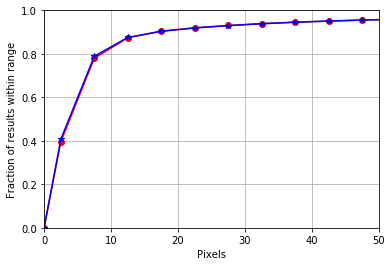

In [48]:
plt.figure(3)

plt.plot(x_v2_7_3,y_v2_7_3,marker='o', color = 'r')
plt.plot(x_v2_3_3,y_v2_3_3,marker='*', color = 'b')
plt.xlabel('Pixels')
plt.ylabel('Fraction of results within range')
plt.xlim(0,50)
plt.ylim(0,1)
plt.grid(True)

# plot images 

In [24]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    images = np.asarray(images)
    images=images*255 # Convert to a numpy array 
    return images

# def load_images(image_paths):
#     # Load the images from disk.
#     images = [imread(path) for path in image_paths]
#     # Convert to a numpy array and return it.
#     return np.asarray(images)


In [25]:
def plot_im(img,cls):
    img = resize(img, (370,img.shape[1]))
    imgplot = plt.imshow(img)
    img[140+cls*5:140+(cls+1)*5,:,0]=1
    img[140+cls*5:140+(cls+1)*5,:,1:]=0
    return img[:,:5,:]



In [26]:
sum_csv_val_path = os.path.join(img_path,'val', 'sum_csv') #TEST
labels_val=pd.read_csv(os.path.join(sum_csv_val_path,'labels_val_'+str(percent)+'percent.csv'))
val_names_list=list(labels_val['Name'])
image_paths_val=[]
for name in val_names_list:
    image_paths_val.append(os.path.join(img_path, 'val', name+'.png')) #maybe no need to add '.png'


In [114]:
some_num=500
# start_stx = 25200
start_stx = 1100
some_images = load_images(image_paths=image_paths_val[start_stx:start_stx+some_num])
some_images_cls = np.array(labels_val['Label'][start_stx:start_stx+some_num])

In [115]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [116]:
predictions = model.predict(input_fn=predict_input_fn)
cls_pred = np.array(list(predictions))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_01_06_mobilenetV2_47bins_kernel_3_3/model.ckpt-80000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


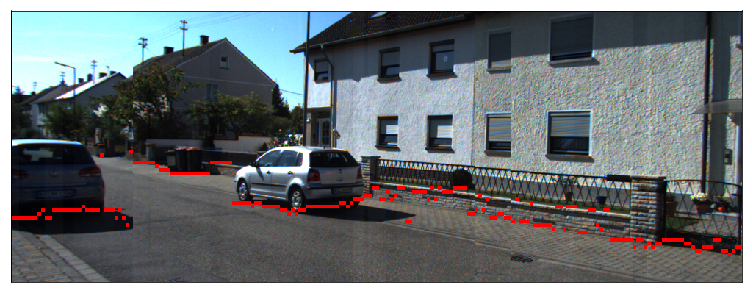

In [126]:
#plotting our preds:
some_images_for_plt = some_images/255.0
img = np.ones([370, 1, 3])
for im in range(cls_pred.shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], cls_pred[im])
    img=np.concatenate([img,img0],axis=1)
# imgplot = plt.imshow(img)
imgplot = plt.imshow(img[:,595:1590,:])
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
# plt.rcParams['figure.figsize'] = [15, 5]

/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/noa_raindel/.TFgpu/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


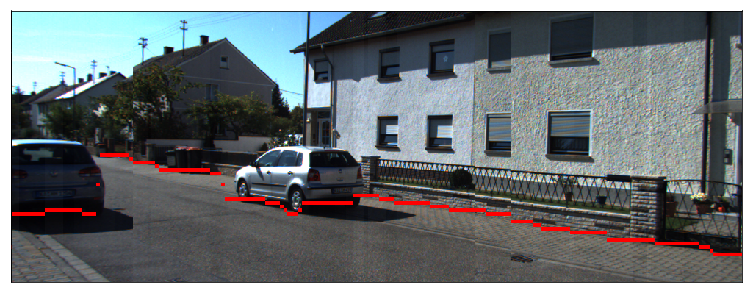

In [125]:
#plotting GT:
some_images_for_plt = some_images[:]/255.0
img = np.ones([370, 1, 3])
for im in range(some_images_cls[:some_num].shape[0]):
    img0 = plot_im(some_images_for_plt[im,:,:,:], some_images_cls[im])
    img=np.concatenate([img,img0],axis=1)
# imgplot = plt.imshow(img[:,1250:1950,:])
# imgplot = plt.imshow(img[:,:,:])
# imgplot = plt.imshow(img[:,794:1510,:]) #25200
imgplot = plt.imshow(img[:,595:1590,:])#1100
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)